In [9]:
import json
from itertools import combinations, chain

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import sklearn.cluster as cls
import sklearn.metrics as met
import sklearn.neighbors as nb

import bachelors_thesis.util as util

In [10]:
data_path = "../../data"
dataset = "all"

In [11]:
# Load road graph
road_graph = util.load_graph(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc.pickle")
road_graph = ox.project_graph(road_graph, to_crs=util.EPSG_32650)

# Load camera info
cameras_dict = util.load(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc_cameras.pickle")

for camera in cameras_dict.values():
    camera["records"] = 0

with open(f"{data_path}/dataset/records-{dataset}.json", mode="r", encoding="utf-8") as file:
    for line in file:
        record = json.loads(line)
        camera = cameras_dict[record["camera_id"]]
        camera["records"] += 1

In [12]:
# Parameters
seed = 666
number_of_regions = 3
colors = ["red", "green", "blue", "yellow", "orange", "cyan", "brown", "pink", "purple"]

Silhouette Score: 0.4932862415622904
Region records:  [1508173, 1673377, 1711800]


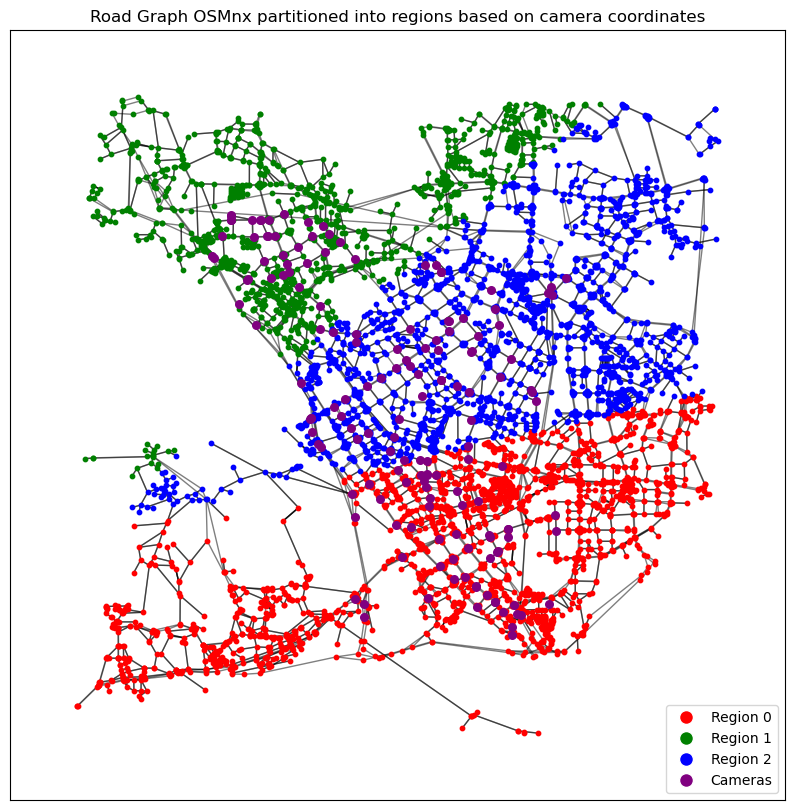

In [13]:
nodes = [{"node_id": node, "x": road_graph.nodes[node]["x"], "y": road_graph.nodes[node]["y"]} for node in
         road_graph.nodes()]
nodes_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

cameras = list(cameras_dict.values())
cameras_nodes = {camera["node_id"] for camera in cameras}
cameras_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])
cameras_coordinates = util.xy_to_epsg4326(cameras_coordinates)
cameras_coordinates = util.epsg4326_to_epsg32650(cameras_coordinates)
cameras_records = np.array([camera["records"] for camera in cameras])

# Clustering based on cameras
k_means = cls.KMeans(number_of_regions, random_state=seed)
regions = k_means.fit_predict(cameras_coordinates, sample_weight=cameras_records)
print(f"Silhouette Score: {met.silhouette_score(cameras_coordinates, regions, random_state=seed)}")

# Record distribution
regions_records = [0 for _ in range(number_of_regions)]
for region, camera in zip(regions, cameras):
    regions_records[region] += camera["records"]
print("Region records: ", regions_records)

# Matching nodes to cluster centroids
kd_tree = nb.KDTree(k_means.cluster_centers_)
indices = kd_tree.query(nodes_coordinates, k=1, return_distance=False)
indices = indices.flatten()

regions_nodes = [set() for _ in range(number_of_regions)]
for index, node in zip(indices, nodes):
    regions_nodes[index].add(node["node_id"])

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pos = {node: (road_graph.nodes[node]["x"], road_graph.nodes[node]["y"]) for node in road_graph.nodes()}

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax
)

for index, nodes_ in enumerate(regions_nodes):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=10,
        nodelist=nodes_,
        ax=ax
    )

ax.scatter(cameras_coordinates[:, 0], cameras_coordinates[:, 1], s=30, c=colors[-1], zorder=100)
ax.set_title("Road Graph OSMnx partitioned into regions based on camera coordinates")

legend = list()
for region in range(number_of_regions):
    legend.append(plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[region], markersize=10,
                             label=f"Region {region}"))
legend.append(plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[-1], markersize=10,
                         label=f"Cameras"))
plt.legend(handles=legend)
plt.show()

In [14]:
def get_number_of_cameras_in_nodes(nodes: set[int], cameras_dict: dict) -> int:
    camera_count = 0
    for camera in cameras_dict.values():
        if camera["node_id"] in nodes:
            camera_count += 1
    return camera_count


def get_number_of_records_for_node(node: int, cameras_dict: dict):
    records = 0
    for camera in cameras_dict.values():
        if camera["node_id"] == node:
            records += camera["records"]
    return records


def get_ids_of_cameras_in_region(region_nodes: set[int], cameras_dict: dict) -> set[int]:
    camera_ids = set()
    for camera in cameras_dict.values():
        if camera["node_id"] in region_nodes:
            camera_ids.add(camera["camera_id"])
    return camera_ids

# TODO: Try another approach (municipality-/district-based, historical data, alphashape, etc.)
def find_auxiliary_regions(G: nx.MultiDiGraph, regions_nodes: list[set[int]]):
    aux_regions = list()
    number_of_regions = len(regions_nodes)

    for i, j in combinations(range(number_of_regions), 2):
        nodes_i = regions_nodes[i]
        nodes_j = regions_nodes[j]

        edges_i_to_j = {(u, v) for u in nodes_i for v in nodes_j if G.has_edge(u, v)}
        edges_j_to_i = {(u, v) for u in nodes_j for v in nodes_i if G.has_edge(u, v)}

        if not edges_i_to_j and not edges_j_to_i:
            print(f"No edges for auxiliary region {i}-{j}")
            continue

        aux_region_nodes = set()
        for u, v in chain(edges_i_to_j, edges_j_to_i):
            aux_region_nodes.add(u)
            aux_region_nodes.add(v)

        aux_regions.append({
            "auxiliary": True,
            "region": (i, j),
            "nodes": aux_region_nodes,
            "edges_i_to_j": edges_i_to_j,
            "edges_j_to_i": edges_j_to_i,
        })

    return aux_regions


def expand_auxiliary_regions(G: nx.MultiDiGraph, aux_regions: list[dict], cameras_dict: dict, *,
                             min_number_of_cameras: int, min_cutoff: int = 1, max_cutoff: int = 10) -> list[dict]:
    G = G.to_undirected()
    expanded_aux_regions = list()

    for aux_region in aux_regions:
        i, j = aux_region["region"]
        aux_region_nodes = aux_region["nodes"]

        selected_cutoff = None
        selected_cutoff_nodes = None
        for cutoff in range(min_cutoff, max_cutoff + 1):
            expanded_aux_region_nodes = set(aux_region_nodes)
            for node in aux_region_nodes:
                expanded_aux_region_nodes.update(nx.single_source_shortest_path_length(G, node, cutoff=cutoff).keys())

            number_of_cameras = get_number_of_cameras_in_nodes(expanded_aux_region_nodes, cameras_dict)
            if number_of_cameras >= min_number_of_cameras:
                selected_cutoff = cutoff
                selected_cutoff_nodes = expanded_aux_region_nodes
                break

        if selected_cutoff is None:
            print(f"No cutoff found that satisfies minimum number of cameras for auxiliary region {i}-{j}")
            continue

        expanded_aux_regions.append({
            "auxiliary": aux_region["auxiliary"],
            "region": aux_region["region"],
            "nodes": selected_cutoff_nodes,
            "cutoff": selected_cutoff,
            "edges_i_to_j": aux_region["edges_i_to_j"],
            "edges_j_to_i": aux_region["edges_j_to_i"],
        })

    return expanded_aux_regions

No edges for auxiliary region 0-1


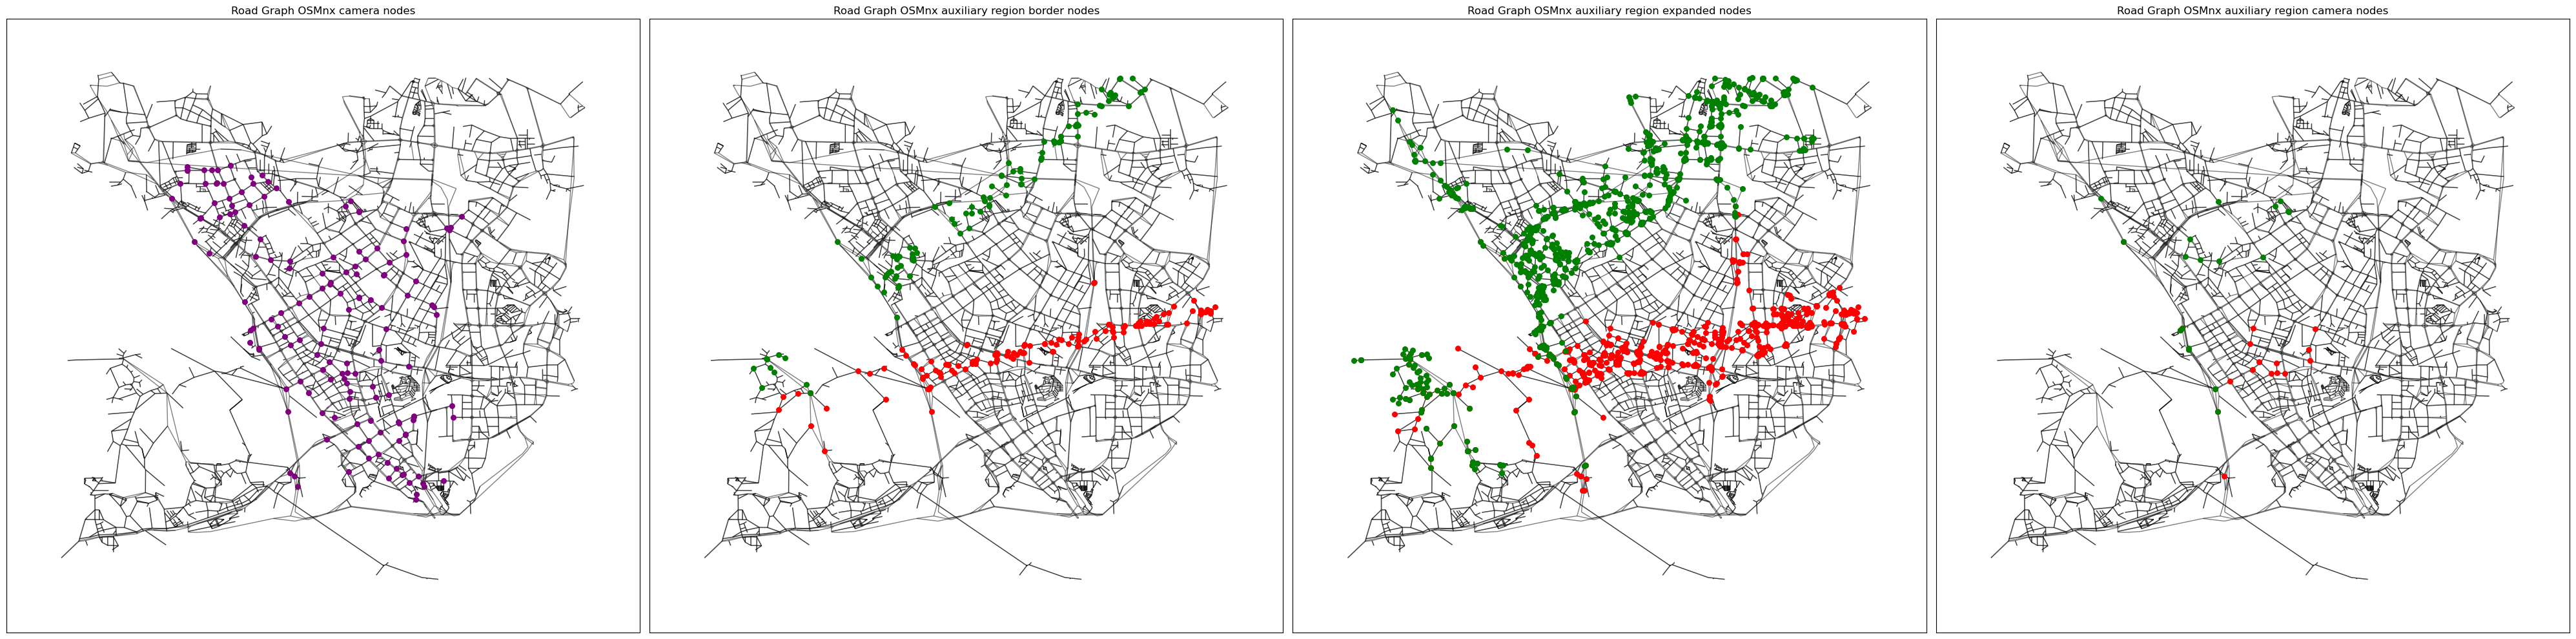

Region 0-2 number of records:  798995
Region 0-2 number of cameras:  23
Region 0-2 number of cameras nodes:  20
Region 0-2 cutoff:  3
Region 1-2 number of records:  617337
Region 1-2 number of cameras:  20
Region 1-2 number of cameras nodes:  18
Region 1-2 cutoff:  5


In [15]:
# Find and visualize auxiliary regions
aux_regions = find_auxiliary_regions(road_graph, regions_nodes)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 10))

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax1
)

nx.draw_networkx_nodes(
    road_graph,
    pos,
    node_color=colors[-1],
    node_size=30,
    nodelist=cameras_nodes,
    ax=ax1
)

ax1.set_title("Road Graph OSMnx camera nodes")

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax2
)

for index, aux_region in enumerate(aux_regions):
    aux_region_nodes = aux_region["nodes"]
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=30,
        nodelist=aux_region_nodes,
        ax=ax2
    )

ax2.set_title("Road Graph OSMnx auxiliary region border nodes")

aux_regions = expand_auxiliary_regions(road_graph, aux_regions, cameras_dict,
                                       min_number_of_cameras=20, min_cutoff=1, max_cutoff=10)

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax3
)

for index, aux_region in enumerate(aux_regions):
    aux_region_nodes = aux_region["nodes"]
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=30,
        nodelist=aux_region_nodes,
        ax=ax3
    )

ax3.set_title("Road Graph OSMnx auxiliary region expanded nodes")

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax4
)

for index, aux_region in enumerate(aux_regions):
    aux_region_nodes = aux_region["nodes"]
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=30,
        nodelist={cameras_dict[camera_id]["node_id"] for camera_id in
                  get_ids_of_cameras_in_region(aux_region_nodes, cameras_dict)},
        ax=ax4
    )

ax4.set_title("Road Graph OSMnx auxiliary region camera nodes")

plt.tight_layout()
plt.show()

for aux_region in aux_regions:
    i, j = aux_region["region"]
    aux_region_nodes = aux_region["nodes"]
    cutoff = aux_region["cutoff"]
    number_of_cameras_in_region = get_number_of_cameras_in_nodes(aux_region_nodes, cameras_dict)
    camera_nodes_in_region = {cameras_dict[camera_id]["node_id"] for camera_id in
                              get_ids_of_cameras_in_region(aux_region_nodes, cameras_dict)}

    records = 0
    for camera_node in camera_nodes_in_region:
        records += get_number_of_records_for_node(camera_node, cameras_dict)

    print(f"Region {i}-{j} number of records: ", records)
    print(f"Region {i}-{j} number of cameras: ", number_of_cameras_in_region)
    print(f"Region {i}-{j} number of cameras nodes: ", len(camera_nodes_in_region))
    print(f"Region {i}-{j} cutoff: ", cutoff)

In [16]:
# Region: {
#     "auxiliary": False,                          Indicates that this is a region
#     "region": int,                               ID of the region
#     "nodes": set[int],                           IDs of nodes that make up this region
#     "cameras": set[int],                         IDs of cameras that are in this region
# }
#
# Auxiliary Region: {
#     "auxiliary": True,                           Indicates that this is an auxiliary region
#     "region": tuple[int, int],                   (i, j): IDs of regions along which this auxiliary region is placed
#     "nodes": set[int],                           IDs of nodes that make up this auxiliary region
#     "cameras": set[int],                         IDs of cameras that are in this auxiliary region
#     "edges_i_to_j": set[tuple[int, int]],        Edges that cross the border in the direction i to j
#     "edges_j_to_i": set[tuple[int, int]],        Edges that cross the border in the direction j to i
# }

regions = dict()
for index, nodes_ in enumerate(regions_nodes):
    camera_ids = get_ids_of_cameras_in_region(nodes_, cameras_dict)
    regions[index] = {
        "auxiliary": False,
        "region": index,
        "nodes": nodes_,
        "cameras": camera_ids,
    }

for aux_region in aux_regions:
    camera_ids = get_ids_of_cameras_in_region(aux_region["nodes"], cameras_dict)
    regions[aux_region["region"]] = {
        "auxiliary": aux_region["auxiliary"],
        "region": aux_region["region"],
        "nodes": aux_region["nodes"],
        "cameras": camera_ids,
        "edges_i_to_j": aux_region["edges_i_to_j"],
        "edges_j_to_i": aux_region["edges_j_to_i"],
    }

util.save(regions, f"{data_path}/road_graph/region_partitioning_{dataset}_{number_of_regions}.pickle")